## 꽃 이미지 분류 (CNN 방식)

이 노트북은 데이지(daisy)와 민들레(dandelion) 이미지를 분류하는 **합성곱 신경망(Convolutional Neural Network, CNN)** 모델을 구축합니다. 이전의 완전 연결 신경망(DNN) 방식과 달리, CNN은 이미지의 공간적 특징(spatial features)을 직접 학습할 수 있어 이미지 분류 작업에 훨씬 더 효과적입니다.

**주요 차이점:**
- **모델 구조**: `Conv2D`와 `MaxPooling2D` 레이어를 사용하여 이미지의 특징을 추출합니다.
- **데이터 형태**: 이미지를 1차원 벡터로 펼치지 않고, `(높이, 너비, 채널)` 형태의 3차원 데이터를 그대로 사용합니다.
- **전처리**: `StandardScaler` 대신 픽셀 값을 0-1 범위로 정규화하는 간단한 스케일링을 사용합니다.

### 1. 라이브러리 임포트 및 기본 설정

In [2]:
import numpy as np
import os
import PIL.Image as pilimg
import imghdr
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
import glob

# 기본 경로 설정
base_path = "../../data/flowers2"

### 2. 데이터 준비: 이미지 파일을 NumPy 배열로 변환

모든 이미지를 일정한 크기(80x80)로 조정하고 NumPy 배열로 변환하여 `.npz` 파일로 저장합니다. 이 과정은 이전 노트북에서 이미 실행했다면 건너뛸 수 있습니다.

In [3]:
def make_data_from_images(flower_name, label, is_train=True):
    """특정 꽃 이미지를 읽어 npz 파일로 저장합니다."""
    path_type = "train" if is_train else "test"
    path = os.path.join(base_path, path_type, flower_name)
    data = []
    labels = []
    
    print(f"'{flower_name}' ({path_type}) 카테고리 처리 시작...")
    if not os.path.exists(path):
        print(f"  경로를 찾을 수 없습니다: {path}")
        return
        
    filenames = os.listdir(path)
    for i, filename in enumerate(filenames):
        if (i + 1) % 100 == 0:
            print(f"  {i + 1} / {len(filenames)} 번째 파일 처리 중...")
        
        file_path = os.path.join(path, filename)
        try:
            if imghdr.what(file_path) in ["gif", "png", "jpeg", "jpg"]:
                img = pilimg.open(file_path)
                resize_img = img.resize((80, 80))
                pixel = np.array(resize_img)
                if pixel.shape == (80, 80, 3):
                    data.append(pixel)
                    labels.append(label)
        except Exception as e:
            print(f"  파일 처리 오류: {filename}, 오류: {e}")

    save_filename = f"imagedata_{label}_{path_type}.npz"
    np.savez(save_filename, data=data, targets=labels)
    print(f"'{flower_name}' ({path_type}) 데이터 저장 완료 -> {save_filename}")

def initialize_dataset():
    """모든 카테고리에 대해 데이터 생성을 수행합니다."""
    if len(glob.glob('imagedata_*.npz')) >= 4:
        print("이미 전처리된 .npz 파일들이 존재합니다. 데이터 생성을 건너뜁니다.")
        return

    flowers = ["daisy", "dandelion"]
    for i, f in enumerate(flowers):
        make_data_from_images(f, i, is_train=True)
        make_data_from_images(f, i, is_train=False)
    print("\n모든 데이터 저장 완료.")

# 데이터 준비 함수 실행
initialize_dataset()

'daisy' (train) 카테고리 처리 시작...
  100 / 529 번째 파일 처리 중...
  200 / 529 번째 파일 처리 중...
  300 / 529 번째 파일 처리 중...
  400 / 529 번째 파일 처리 중...
  500 / 529 번째 파일 처리 중...
'daisy' (train) 데이터 저장 완료 -> imagedata_0_train.npz
'daisy' (test) 카테고리 처리 시작...
'daisy' (test) 데이터 저장 완료 -> imagedata_0_test.npz
'dandelion' (train) 카테고리 처리 시작...
  100 / 746 번째 파일 처리 중...
  200 / 746 번째 파일 처리 중...
  300 / 746 번째 파일 처리 중...
  400 / 746 번째 파일 처리 중...
  500 / 746 번째 파일 처리 중...
  600 / 746 번째 파일 처리 중...
  700 / 746 번째 파일 처리 중...
'dandelion' (train) 데이터 저장 완료 -> imagedata_1_train.npz
'dandelion' (test) 카테고리 처리 시작...
  100 / 105 번째 파일 처리 중...
'dandelion' (test) 데이터 저장 완료 -> imagedata_1_test.npz

모든 데이터 저장 완료.


### 3. 데이터 로딩 및 전처리 (CNN 방식)
CNN 모델은 이미지의 2D 구조를 그대로 입력받으므로, 데이터를 1차원 벡터로 펼치지 않습니다. 픽셀 값을 0-1 사이로 정규화하는 스케일링만 적용합니다.

In [4]:
def load_and_preprocess_for_cnn():
    """npz 파일들을 로드하고 CNN에 맞게 전처리합니다."""
    with np.load("imagedata_0_train.npz") as f1, np.load("imagedata_1_train.npz") as f2:
        X_train = np.concatenate((f1["data"], f2["data"]), axis=0)
        y_train = np.concatenate((f1["targets"], f2["targets"]), axis=0)

    with np.load("imagedata_0_test.npz") as f1, np.load("imagedata_1_test.npz") as f2:
        X_test = np.concatenate((f1["data"], f2["data"]), axis=0)
        y_test = np.concatenate((f1["targets"], f2["targets"]), axis=0)
        
    # 스케일링 (0-1 범위로 정규화)
    X_train_scaled = X_train.astype('float32') / 255.0
    X_test_scaled = X_test.astype('float32') / 255.0
    
    return X_train_scaled, y_train, X_test_scaled, y_test

X_train, y_train, X_test, y_test = load_and_preprocess_for_cnn()

print("--- CNN용 데이터 형태 ---")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

--- CNN용 데이터 형태 ---
X_train shape: (1275, 80, 80, 3)
y_train shape: (1275,)


### 4. CNN 모델 구축
합성곱 신경망(CNN) 모델을 정의합니다.
- **Conv2D & MaxPooling2D**: 이미지의 특징을 효과적으로 추출하고 다운샘플링하는 부분입니다.
- **Flatten**: 추출된 2D 특징 맵을 1D 벡터로 변환하여 완전 연결층에 전달합니다.
- **Dense**: 최종적으로 클래스를 분류하는 부분입니다. 이진 분류이므로 마지막 층은 `sigmoid` 활성화 함수를 사용합니다.

In [5]:
def create_cnn_model():
    network = models.Sequential([
        # 입력 형태는 (80, 80, 3) 입니다.
        layers.Input(shape=(80, 80, 3)),
        
        # Convolutional Base
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        
        # Classifier Head
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

    network.compile(optimizer='rmsprop',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    return network

model = create_cnn_model()
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 39, 39, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 43808)             0         
                                                                 
 dense (Dense)               (None, 128)               5607552   
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                     

### 5. 모델 훈련
전처리된 데이터를 사용하여 CNN 모델을 학습시킵니다.

In [6]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=100,
                    validation_data=(X_test, y_test))

Epoch 1/100


13/13 [==============================] - 4s 272ms/step - loss: 0.8340 - accuracy: 0.5600 - val_loss: 0.6753 - val_accuracy: 0.5769
Epoch 2/100
13/13 [==============================] - 3s 240ms/step - loss: 0.6673 - accuracy: 0.5812 - val_loss: 0.6463 - val_accuracy: 0.5769
Epoch 3/100
13/13 [==============================] - 3s 271ms/step - loss: 0.6540 - accuracy: 0.5820 - val_loss: 0.6426 - val_accuracy: 0.5824
Epoch 4/100
13/13 [==============================] - 4s 278ms/step - loss: 0.6333 - accuracy: 0.6024 - val_loss: 0.5929 - val_accuracy: 0.6703
Epoch 5/100
13/13 [==============================] - 4s 294ms/step - loss: 0.6317 - accuracy: 0.6298 - val_loss: 0.6434 - val_accuracy: 0.5769
Epoch 6/100
13/13 [==============================] - 4s 320ms/step - loss: 0.6248 - accuracy: 0.6376 - val_loss: 0.6099 - val_accuracy: 0.6319
Epoch 7/100
13/13 [==============================] - 4s 294ms/step - loss: 0.5801 - accuracy: 0.6839 - val_loss: 0.5699 - val_accuracy: 0.68

### 6. 모델 평가 및 결과 시각화
훈련된 CNN 모델의 최종 성능을 평가하고, 훈련 과정을 시각화하여 학습 상태를 분석합니다.


--- 최종 모델 평가 ---
훈련셋   => 손실값: 0.0000, 정확도: 1.0000
테스트셋 => 손실값: 1.7510, 정확도: 0.8022


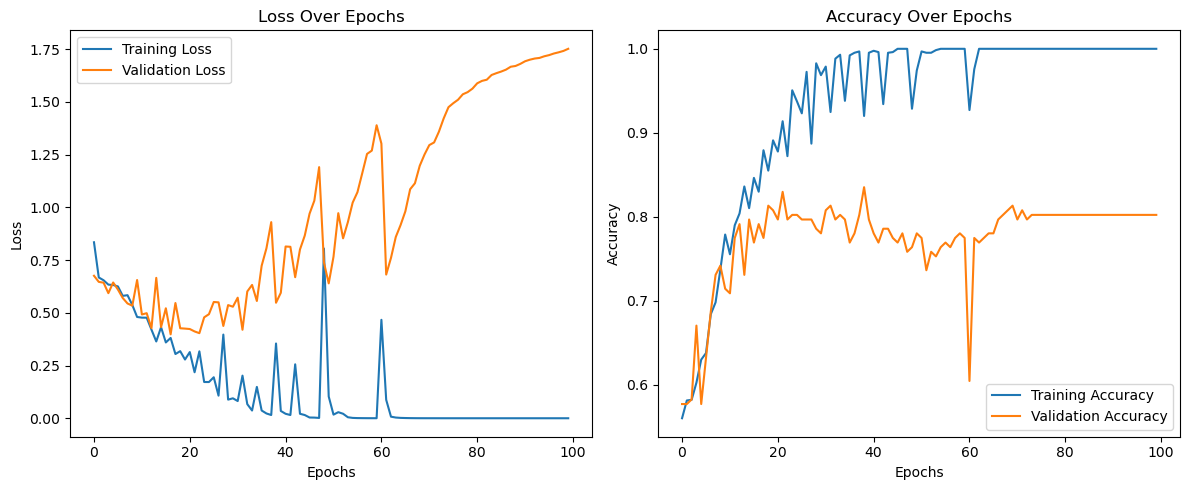

In [7]:
print("\n--- 최종 모델 평가 ---")
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"훈련셋   => 손실값: {train_loss:.4f}, 정확도: {train_acc:.4f}")
print(f"테스트셋 => 손실값: {test_loss:.4f}, 정확도: {test_acc:.4f}")

# 훈련 과정 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()